## Modeling

### Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')

from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

springfield = pd.read_csv('data/springfield.csv', index_col='date')
springfield_diff = pd.read_csv('data/springfield_diff.csv', index_col='date')

### Train/Test Split

In [2]:
# dataset that is already .diff()
sf_diff_train = springfield_diff[0:220]
sf_diff_test = springfield_diff[220:]

# original working dataset
sf_train = springfield_diff[0:220]
sf_test = springfield_diff[220:]

## ARMA

In [3]:
springfield_diff

,65807,65802,65804,65810,65806,65809
date,,,,,,
1996-05-01,0.000000,-0.004961,0.000000,-0.004282,-0.003546,-0.000578
1996-06-01,0.000751,-0.003766,0.000730,-0.003019,-0.003361,0.000227
1996-07-01,0.001444,-0.002612,0.001403,-0.001807,-0.001381,0.000543
1996-08-01,0.002076,-0.001508,0.001150,-0.000023,-0.005402,0.000864
1996-09-01,0.003565,0.000750,0.003682,0.001590,-0.002670,0.000692
...,...,...,...,...,...,...
2017-12-01,-0.001306,0.000734,-0.002522,-0.001310,0.016950,-0.001382
2018-01-01,-0.000414,0.000583,-0.003308,0.000199,0.002960,-0.001162
2018-02-01,0.001711,-0.000419,0.003128,0.005340,-0.004378,0.008113


### ACF

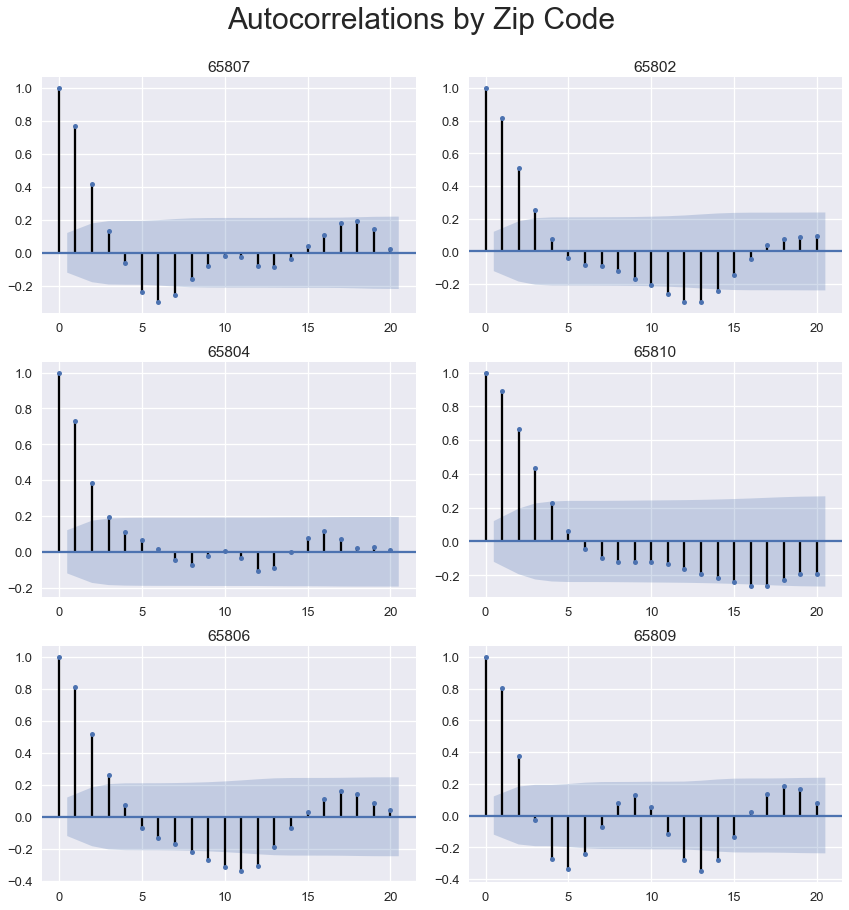

In [4]:
n = len(springfield_diff.columns)
fig, axs = plt.subplots(int(np.ceil(n/2)), 2, figsize=(12, 12))
fig.suptitle('Autocorrelations by Zip Code', y=1.05, fontsize=30)
axs_flat = axs.flatten()

for i, col in enumerate(springfield_diff.columns):
    plot_acf(springfield_diff[col], ax=axs_flat[i], lags=20, title=col)

plt.tight_layout()
plt.savefig('visualizations/autocorrelations.png')
plt.show()

### PACF

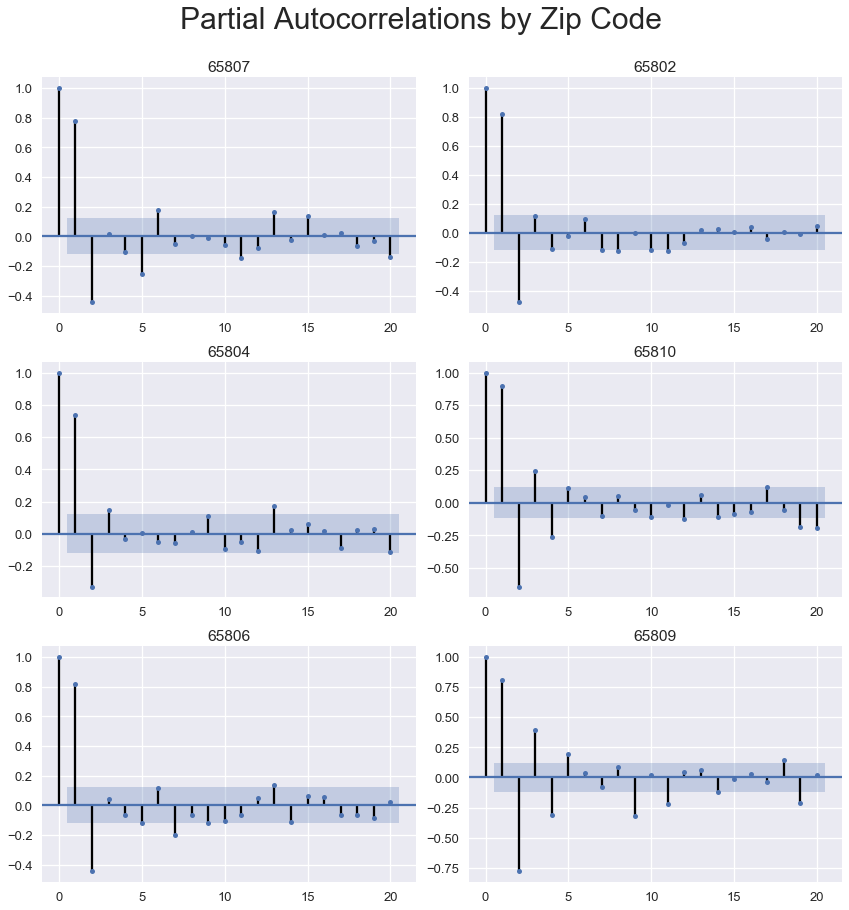

In [5]:
n = len(springfield_diff.columns)
fig, axs = plt.subplots(int(np.ceil(n/2)), 2, figsize=(12, 12))
fig.suptitle('Partial Autocorrelations by Zip Code', y=1.05, fontsize=30)
axs_flat = axs.flatten()

for i, col in enumerate(springfield_diff.columns):
    plot_pacf(springfield_diff[col], ax=axs_flat[i], lags=20, title=col)

plt.tight_layout()
plt.savefig('visualizations/partial-autocorrelations.png')
plt.show()

### Model

> order is (p,q) p is determined by the AR (pacf), q is determined by the MA (acf)

In [6]:
for col in sf_diff_train:
    
    #creating the ARMA Model
    mod_arma = ARMA(sf_diff_train[col], order=(1,0), freq='MS')
    res_arma = mod_arma.fit()
    print(res_arma.summary())
    
    #predictions
    pred_start_date = sf_diff_test.index[0]
    pred_end_date = sf_diff_test.index[-1]
    predictions = res_arma.predict(start=pred_start_date, end=pred_end_date)
    
    #RMSE
    residuals = sf_diff_test[col] - predictions
    RMSE = np.sqrt(np.mean(residuals**2))

    print('RMSE: ', RMSE)
    print('\n \n \n')

                              ARMA Model Results                              
Dep. Variable:                  65807   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood                1088.602
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 27 Jan 2021   AIC                          -2171.204
Time:                        05:31:34   BIC                          -2161.023
Sample:                    05-01-1996   HQIC                         -2167.093
                         - 08-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.746e-05      0.001      0.076      0.940      -0.001       0.001
ar.L1.65807     0.8194      0.038     21.624      0.000       0.745       0.894
                                    Roots       

### Testing code, not ready to delete yet

In [7]:
mod_arma = ARMA(sf_diff_train['65807'], order=(1,0), freq='MS')

res_arma = mod_arma.fit()
    
print(res_arma.summary())

                              ARMA Model Results                              
Dep. Variable:                  65807   No. Observations:                  220
Model:                     ARMA(1, 0)   Log Likelihood                1088.602
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 27 Jan 2021   AIC                          -2171.204
Time:                        05:31:35   BIC                          -2161.023
Sample:                    05-01-1996   HQIC                         -2167.093
                         - 08-01-2014                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4.746e-05      0.001      0.076      0.940      -0.001       0.001
ar.L1.65807     0.8194      0.038     21.624      0.000       0.745       0.894
                                    Roots       

In [8]:
pred_start_date = sf_diff_test.index[0]
pred_end_date = sf_diff_test.index[-1]
predictions = res_arma.predict(start=pred_start_date, end=pred_end_date)    

In [9]:
residuals = sf_diff_test['65807'] - predictions

RMSE = np.sqrt(np.mean(residuals**2))

print('RMSE: ', RMSE)

RMSE:  0.002806353788351516


> log(springfield) - log(springfield).ewm(halflife=4).mean().diff()

We might need to un-transform the data values for RMSE to make sense?.

In [12]:
from statsmodels.tsa.stattools import adfuller

def stationarity_check(data, title='Housing Prices over Time by Zip Code in Springfield, Missouri', filename='tmp'):
    data.plot(title=title)
    plt.xlabel('Year')
    plt.ylabel('Housing Prices')
    plt.tight_layout()
    plt.savefig(f'visualizations/{filename}.png')
    plt.show()
    
    for col in data.columns:
        print (f'Dickey-Fuller Test for zip code {col}: \n')
        dftest = adfuller(data[col])
        print(pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']), '\n')

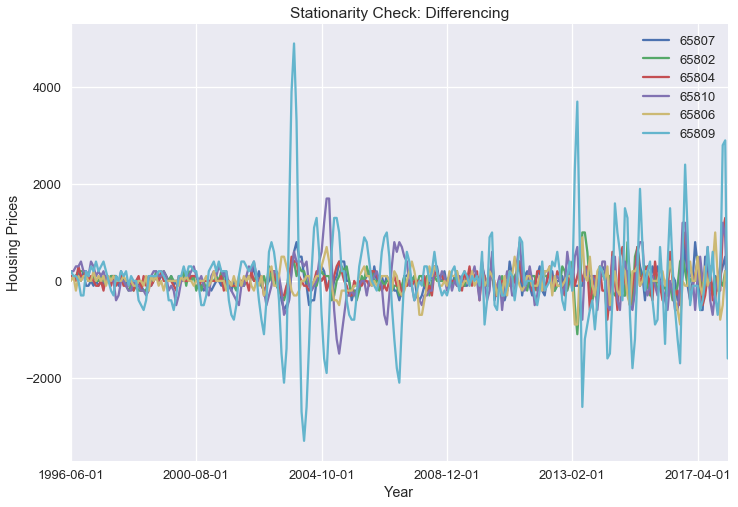

Dickey-Fuller Test for zip code 65807: 

Test Statistic                -7.212897e+00
p-value                        2.211072e-10
#Lags Used                     1.300000e+01
Number of Observations Used    2.490000e+02
dtype: float64 

Dickey-Fuller Test for zip code 65802: 

Test Statistic                -6.829043e+00
p-value                        1.914570e-09
#Lags Used                     1.300000e+01
Number of Observations Used    2.490000e+02
dtype: float64 

Dickey-Fuller Test for zip code 65804: 

Test Statistic                -6.734619e+00
p-value                        3.231016e-09
#Lags Used                     1.100000e+01
Number of Observations Used    2.510000e+02
dtype: float64 

Dickey-Fuller Test for zip code 65810: 

Test Statistic                -8.479450e+00
p-value                        1.406049e-13
#Lags Used                     4.000000e+00
Number of Observations Used    2.580000e+02
dtype: float64 

Dickey-Fuller Test for zip code 65806: 

Test Statistic         

In [14]:
springfield_diff = springfield.diff(periods=1).dropna()
springfield_diff_2 = springfield_diff.diff(periods=1).dropna()
stationarity_check(springfield_diff_2, 'Stationarity Check: Differencing', 'stationarity-check-diff')

## ARIMA

In [15]:
from statsmodels.tsa.arima_model import ARIMA

In [16]:
sf_train['65807']

date
1996-05-01    0.000000
1996-06-01    0.000751
1996-07-01    0.001444
1996-08-01    0.002076
1996-09-01    0.003565
                ...   
2014-04-01   -0.000536
2014-05-01   -0.001273
2014-06-01    0.002197
2014-07-01    0.001828
2014-08-01   -0.000909
Name: 65807, Length: 220, dtype: float64

In [17]:
arima = ARIMA(sf_train['65807'], order=(1,2,0)).fit()
trainpreds = np.append(np.array([0]), np.array(arima.predict()))
testpreds = arima.forecast()[0]
arima.summary()

C:\Users\Deric\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Deric\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.65807   No. Observations:                  218
Model:                 ARIMA(1, 2, 0)   Log Likelihood                1051.155
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 27 Jan 2021   AIC                          -2096.311
Time:                        05:32:54   BIC                          -2086.157
Sample:                    07-01-1996   HQIC                         -2092.210
                         - 08-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.381e-05      0.000     -0.131      0.896      -0.000       0.000
ar.L1.D2.65807    -0.2483      0.066     -3.783      0.000      -0.377      -0.120
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.0273           +0.0000j            4.0273            0.5000
-----------------------------------------------------------------------------
"""

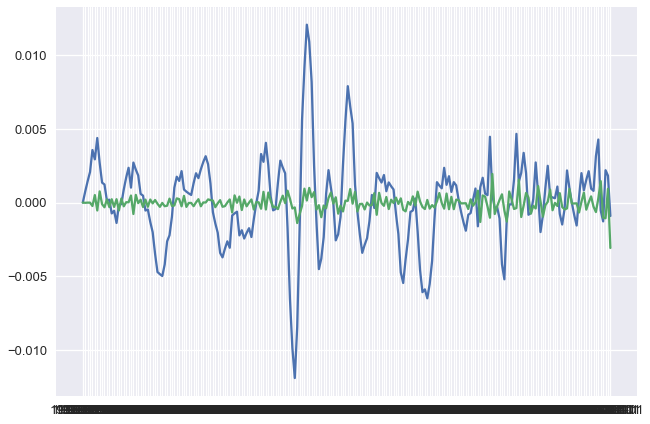

In [18]:
plt.plot(sf_train['65807'])
plt.plot(np.append(trainpreds, testpreds))
plt.show()

## Auto-ARIMA

## Facebook Prophet